# Моделирование

«Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.» Также, добавим месяц.

In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import random
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import torch
from etna.analysis import plot_backtest, plot_forecast
from etna.datasets import TSDataset
from etna.metrics import R2, SMAPE
from etna.models.nn import ChronosBoltModel, ChronosModel
from etna.pipeline import Pipeline
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

In [3]:
def smape(y_true, y_pred):
    """Calculate SMAPE error"""
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator/denominator)


def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def load_df(path: str):
    """Load data and return as dataframe"""
    df = pd.read_csv(path)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.loc[df["holiday"].isnull(), "holiday"] = "None"
    return df


def add_feature_as_hours_to_df(df):
    """Add hours as the feature to dataframe"""
    df["hour"] = df["date_time"].dt.hour


def add_feature_as_day_of_the_week_to_df(df):
    """Add day of the week  as the feature to dataframe"""
    df["day_of_the_week"] = df["date_time"].dt.weekday


def add_feature_as_month_to_df(df):
    """Add month as the feature to dataframe"""
    df["month"] = df["date_time"].dt.month


def add_features_set_to_df(df):
    """Add features set to dataframe"""
    add_feature_as_hours_to_df(df)
    add_feature_as_day_of_the_week_to_df(df)
    add_feature_as_month_to_df(df)


def show_metrics_from_etna(ts_true: TSDataset, 
                           ts_in_fact: TSDataset,
                           model_name: str):
    """Print and plot SMAPE, R² metrics and a diagram by ETNA framework"""

    def expand_string(s: str, expected_len: int) -> str:
        len_s = len(s)
        if len_s < expected_len:
            return s + " " * (expected_len - len_s)
        return s

    smape_etna_func = SMAPE(mode="macro")
    smape_etna = smape_etna_func(y_true=ts_true, y_pred=ts_in_fact)
    
    message_SMAPE = f"Average SMAPE for {model_name}: "
    message_R2 = f"Average R² for {model_name}: "
    message_len = max(len(message_R2), len(message_SMAPE))
    message_SMAPE = expand_string(message_SMAPE, message_len)
    message_R2 = expand_string(message_R2, message_len)

    print(f"{message_SMAPE}{smape_etna / 100.:.3f}")
    r2_etna_func = R2(mode="macro")
    r2_etna = r2_etna_func(y_true=ts_true, y_pred=ts_in_fact)
    print(f"{message_R2}{r2_etna:.3f}")
    plot_forecast(forecast_ts=ts_in_fact, test_ts=ts_true)


def add_y_predict_to_df(df: pd.core.frame.DataFrame,
                        y_predict: list,
                        title: str):
    df["traffic_volume_"+title] = y_predict

In [8]:
df_train = load_df("Metro_Interstate_Traffic_Volume_train.csv")
df_test = load_df("Metro_Interstate_Traffic_Volume_test.csv")

In [77]:
add_features_set_to_df(df_test)
add_features_set_to_df(df_train)

print(df_test.head)

<bound method NDFrame.head of               date_time holiday    temp  traffic_volume  hour  \
0   2018-09-16 23:00:00    None  297.44            1088    23   
1   2018-09-17 00:00:00    None  296.58             550     0   
2   2018-09-17 01:00:00    None  296.19             280     1   
3   2018-09-17 02:00:00    None  295.82             260     2   
4   2018-09-17 03:00:00    None  295.83             344     3   
..                  ...     ...     ...             ...   ...   
332 2018-09-30 19:00:00    None  283.45            3543    19   
333 2018-09-30 20:00:00    None  282.76            2781    20   
334 2018-09-30 21:00:00    None  282.73            2159    21   
335 2018-09-30 22:00:00    None  282.09            1450    22   
336 2018-09-30 23:00:00    None  282.12             954    23   

     day_of_the_week  month  
0                  6      9  
1                  0      9  
2                  0      9  
3                  0      9  
4                  0      9  
..       

## Baseline прогноз

По средним значениям вычислим метрики, чтобы оценивать последующие модели.

In [9]:
def get_baseline_value(df, day_of_the_week: int, hour: int):
    """Baseline „model”"""
    return df.iat[24 * day_of_the_week + hour]

In [11]:
df_baseline = df_train.groupby(["day_of_the_week", "hour"])["traffic_volume"]\
    .mean()

df_baseline

day_of_the_week  hour
0                0        653.773050
                 1        406.312057
                 2        307.751773
                 3        369.205674
                 4        856.581560
                            ...     
6                19      3165.880282
                 20      2803.302817
                 21      2379.345070
                 22      1836.267606
                 23      1244.808511
Name: traffic_volume, Length: 168, dtype: float64

## Метрики

Используем метрики SMAPE, R² — доля объясненной дисперсии.

In [12]:
y_label = df_test["traffic_volume"]
y_predict = [get_baseline_value(df_baseline, row.day_of_the_week, row.hour)
             for _, row in df_test.iterrows()
             ]
error_smape = smape(y_label, y_predict)
print(f"Baseline model:\nSMAPE error \t= {error_smape:.3f}")
error_r2 = r2_score(y_label, y_predict)
print(f"R² score \t= {error_r2:.3f}")
y_predict_baseline_stats = y_predict

Baseline model:
SMAPE error 	= 0.084
R² score 	= 0.977


## SARIMAX

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [111]:
sarima = SARIMAX(
    df_train["traffic_volume"],
    order=(4, 0, 1),
    seasonal_order=(0, 0, 1, 24)
     ).fit()

print(sarima.params)

ar.L1            2.454020
ar.L2           -2.115223
ar.L3            0.718977
ar.L4           -0.057861
ma.L1           -0.995982
ma.S.L24         0.471091
sigma2      257485.550807
dtype: float64


In [112]:
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                23758
Model:             SARIMAX(4, 0, 1)x(0, 0, 1, 24)   Log Likelihood             -181869.151
Date:                            Sun, 16 Feb 2025   AIC                         363752.303
Time:                                    21:57:17   BIC                         363808.832
Sample:                                         0   HQIC                        363770.644
                                          - 23758                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4540      0.005    477.589      0.000       2.444       2.464
ar.L2         -2.1152      0.013   

In [99]:
def predict_sarima(sarima_model, offset_train_df, y_test):
    """ Make predictions on the test set """
    y_pred_sarima = sarima_model.predict(
        start=offset_train_df,
        end=offset_train_df + len(y_test)-1,
        dynamic=False
    )
    return y_pred_sarima.reset_index(drop=True)


def evaluate_sarima(sarima_model, offset_train_df, y_test):
    """ Run predictions and print metrics on the test set """
    y_pred_sarima = predict_sarima(sarima_model, offset_train_df, y_test)

    error_smape_sarima = smape(y_test, y_pred_sarima)
    print(f"Baseline model:\nSMAPE error \t= {error_smape_sarima:.3f}")
    error_r2_sarima = r2_score(y_test, y_pred_sarima)
    print(f"R² score \t= {error_r2_sarima:.3f}")

### Оценка на двух неделях

In [113]:
evaluate_sarima(
    sarima,
    len(df_train),
    df_test["traffic_volume"]
)

y_predict_sarima = predict_sarima(
    sarima,
    len(df_train),
    df_test["traffic_volume"]
)

Baseline model:
SMAPE error 	= 0.683
R² score 	= -0.143


### Оценка на одной неделе

In [114]:
evaluate_sarima(
    sarima,
    len(df_train),
    df_test["traffic_volume"].loc[:24*7]
)

Baseline model:
SMAPE error 	= 0.642
R² score 	= -0.047


### Оценка на сутках

In [132]:
evaluate_sarima(
    sarima,
    len(df_train),
    df_test["traffic_volume"].loc[:24]
)

Baseline model:
SMAPE error 	= 0.566
R² score 	= 0.268


### Выводы

| Модель | Тестовый период | SMAPE error | R² score |
|--------|-----------------|-------------|----------|
|ARMA 2-0-2|1 неделя|1.869 |-2.870 |
|SARMA 2-0-2 (0-0-1-24)|2 недели|1.898|-2.804|
|SARMA 2-0-2 (0-0-1-24)|1 неделя|1.796|-2.698|
|SARMA 2-0-2 (0-0-1-24)|1 сутки|0.973|-1.070|
|SARMA 2-0-2 (0-0-1-24)|4 часа|0.268 |0.790 |
|SARMA 4-0-1 (0-0-1-24)|2 недели|0.683|-0.143|
|SARMA 4-0-1 (0-0-1-24)|1 неделя|0.642|-0.047|
|SARMA 4-0-1 (0-0-1-24)|1 сутки|0.566|0.268|
|SARMA 4-0-1 (0-0-1-24)|8 часов|0.811|0.333|

SARMA справилась лучше, чем ARMA.<br />
SARMA 2-0-2 (0-0-1-24): хорошо предсказала первые 4 часа.<br />
SARMA 4-0-1 (0-0-1-24): показала лучше метрики на первых сутках.

## Tinkoff ETNA

Используем трансформерную модель Amazon Chronos.

In [61]:
set_seed(1)

HORIZON = 24 * 14
TRAIN_SIZE = 24 * 90

metrics = [SMAPE(), R2()]

path_to_chronos_model = "H:\\Инструменты\\Windows\\GPT or another LLM\
\\amazon chronos-t5-small 2024"

### Сделаем предварительную оценку на кросс-валидации

Подходит ли модель под данную задачу.

In [62]:
def preprocessing_df(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df["holiday"] = df.holiday.map(lambda it: int(it != "None"))
    return df


def df_to_etna_ts(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df["segment"] = "metro"
    df_processed = df.rename(
        columns={"date_time":"timestamp", "traffic_volume":"target"}
    )
    return TSDataset(df=TSDataset.to_dataset(df_processed), freq="h")


ts = df_to_etna_ts(preprocessing_df(df_train))
dataset_length = ts.size()[0]
ts.head()

segment                       metro                                   
feature             day_of_the_week holiday hour month target     temp
timestamp                                                             
2016-01-01 01:00:00               4       1    1     1   1550  266.000
2016-01-01 02:00:00               4       1    2     1   1134  266.005
2016-01-01 03:00:00               4       1    3     1    719  266.010
2016-01-01 04:00:00               4       1    4     1    533  264.800
2016-01-01 05:00:00               4       1    5     1    586  264.380

In [63]:
model_chronos = ChronosModel(
    path_or_url=path_to_chronos_model,
    encoder_length=min(dataset_length, TRAIN_SIZE),
    num_samples=1
)

pipeline_etna = Pipeline(
    model=model_chronos,
    horizon=HORIZON,
    transforms=[]
)

metrics_chronos, forecast_chronos, fold_info_chronos = pipeline_etna.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


In [64]:
smape_etna = metrics_chronos["SMAPE"].mean()
print(f"Average SMAPE for Chronos small: \t{smape_etna / 100.:.3f}")
r2_etna = metrics_chronos["R2"].mean()
print(f"Average R² for Chronos small: \t\t{r2_etna:.3f}")

Average SMAPE for Chronos small: 	0.088
Average R² for Chronos small: 		0.952


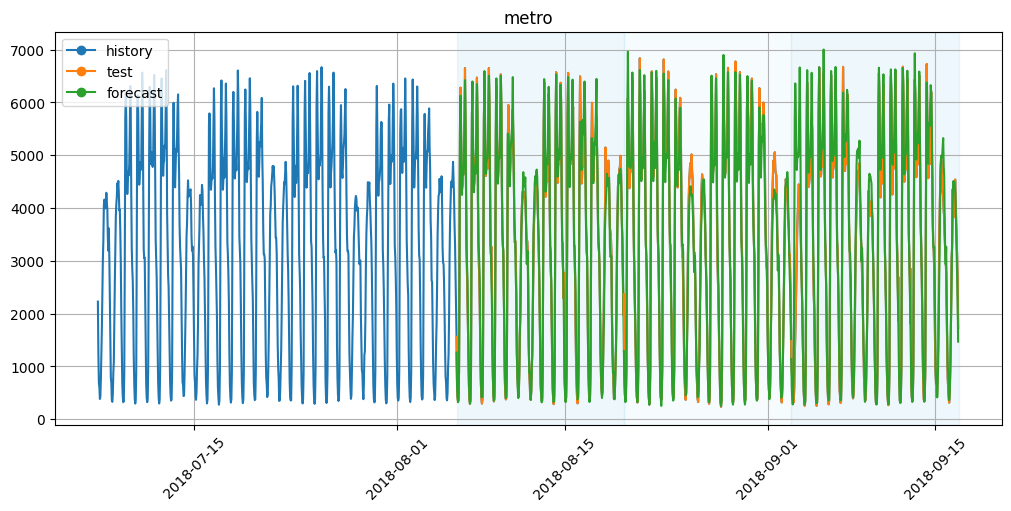

In [65]:
plot_backtest(forecast_chronos, ts, history_len=24*30)

Модель хорошо справилась.

### Тест

Выполним inference на тестовом наборе данных.

In [66]:
ts_test = df_to_etna_ts(preprocessing_df(df_test.loc[:336-1]))

In [67]:
ts_predict = pipeline_etna.forecast(ts)

In [68]:
df_etna_chronos_predict = ts_predict.df
y_predict_chronos_small = list(df_etna_chronos_predict["metro"]["target"])

Average SMAPE for Chronos small: 0.095
Average R² for Chronos small:    0.959


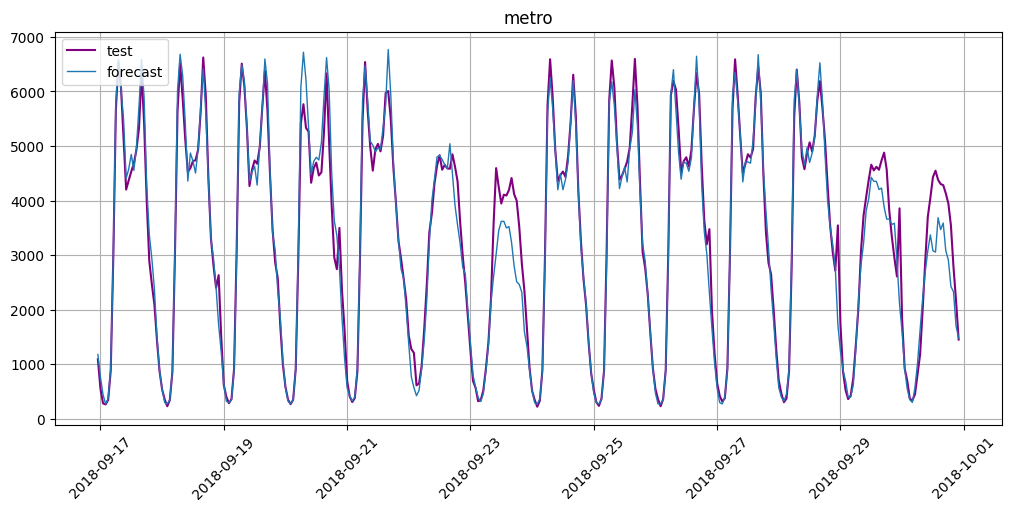

In [69]:
show_metrics_from_etna(ts_test, ts_predict, "Chronos small")

### Chronos Bolt

Используем трансформерную модель Amazon Chronos Bolt: «…Chronos Bolt is one more Chronos-like model with faster and more accurate forecasts.…».

В Интернет опубликованы данные, что Chronos Bolt значительно быстрее, чем Chronos, поэтому используем модель больше по размеру: base.

In [84]:
path_to_chronos_bolt_model = "H:\\Инструменты\\Windows\\GPT or another LLM\
\\amazon chronos-bolt-base 2024"

In [85]:
model_chronos_bolt = ChronosBoltModel(
    path_or_url=path_to_chronos_bolt_model,
    encoder_length=min(dataset_length, TRAIN_SIZE)
)

pipeline_etna_bolt = Pipeline(
    model=model_chronos_bolt,
    horizon=HORIZON,
    transforms=[]
)

metrics_cbolt, forecast_cbolt, fold_info_cbolt = pipeline_etna_bolt.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s


### Сделаем предварительную оценку на кросс-валидации

In [17]:
smape_etna_bolt = metrics_cbolt["SMAPE"].mean()
print(f"Average SMAPE for Chronos Bolt base: \t{smape_etna_bolt / 100.:.3f}")
r2_etna_bolt = metrics_cbolt["R2"].mean()
print(f"Average R² for Chronos Bolt base: \t{r2_etna_bolt:.3f}")

Average SMAPE for Chronos Bolt base: 	0.097
Average R² for Chronos Bolt base: 	0.953


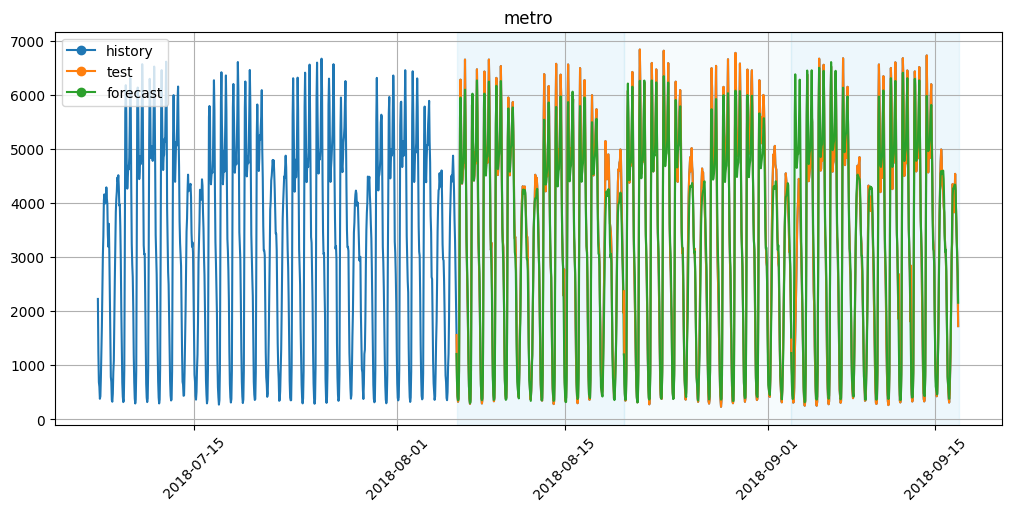

In [18]:
plot_backtest(forecast_cbolt, ts, history_len=24*30)

Модель хорошо справилась.<br />
Время выполнения backtest получилось раза в два меньше, чем с моделью Chronos small.

### Тест

Выполним inference на тестовом наборе данных.

In [86]:
ts_predict_bolt = pipeline_etna_bolt.forecast(ts)

In [87]:
df_etna_chronos_bolt_predict = ts_predict_bolt.df
y_predict_chronos_bolt_base = list(df_etna_chronos_bolt_predict["metro"]["target"])

Average SMAPE for Chronos Bolt base: 0.091
Average R² for Chronos Bolt base:    0.977


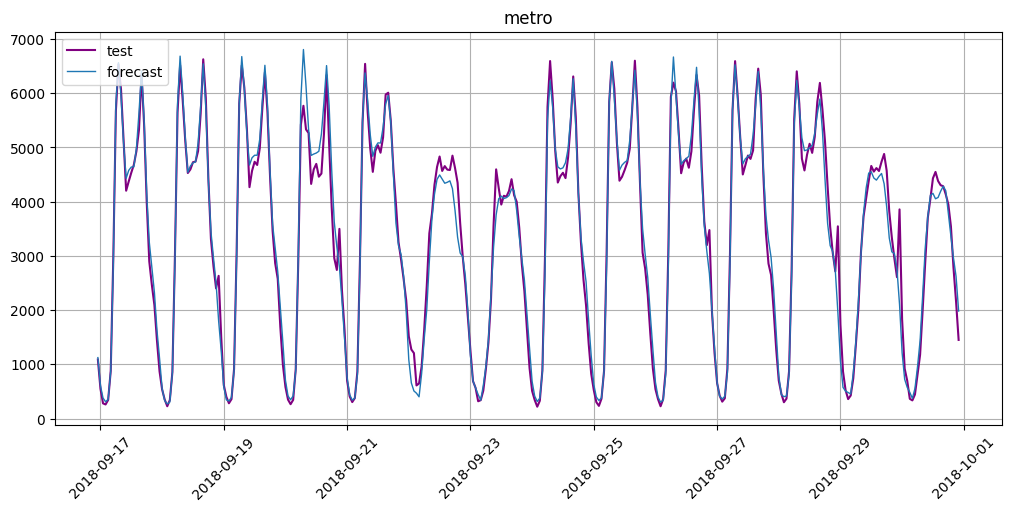

In [88]:
show_metrics_from_etna(ts_test, ts_predict_bolt, "Chronos Bolt base")

## Fine-tune

Сделаем fine-tuned специализированную по данной задаче модель: Chronos Bolt base + корректирующая FNN — Chronos Bolt base оставим без изменений, но добавим к его выходу корректор на основе FNN.
- <a href="3.2.Fine-tune_render_train_data.ipynb">3.2.Fine-tune_render_train_data.ipynb</a> — сгенерируем тренировочный набор данных для FNN;
- <a href="3.3.Fine-tune_train_and_test_fnn.ipynb">3.3.Fine-tune_train_and_test_fnn.ipynb</a> — выполним тренировку корректирующей FNN и снимем тестовые данные с комбинированной (fine-tuned под задачу) модели.

Average SMAPE for Fine-tuned Chronos Bolt base + FNN: 0.071<br />
Average R² for Fine-tuned Chronos Bolt base + FNN:    0.982

## Выводы

Тестовый период: две недели.

| Модель | SMAPE error | R² score |
|--------|-------------|----------|
|Простая статистика с усреднением (Baseline прогноз)|0.084|0.977|
|SARMA 2-0-2 (0-0-1-24)|1.898|-2.804|
|SARMA 4-0-1 (0-0-1-24)|0.683|-0.143|
|Chronos small|0.095|0.959|
|Chronos Bolt base|0.091|0.977|
|Fine-tuned model (Chronos Bolt base + FNN)|0.071|0.982|

Построим графики.

In [ ]:
add_y_predict_to_df(
    df_test,
    y_predict_baseline_stats,
    "baseline_stats"
)

In [ ]:
add_y_predict_to_df(
    df_test,
    y_predict_sarima,
    "sarma_4_0_1"  # "sarma" — для SARMA 2-0-2 (0-0-1-24)
)

In [ ]:
y_predict_chronos_small.append(None)  # Chronos выдал на одну точку меньше
add_y_predict_to_df(
    df_test,
    y_predict_chronos_small,
    "chronos_small"
)

In [91]:
y_predict_chronos_bolt_base.append(None)  # Chronos выдал на одну точку меньше
add_y_predict_to_df(
    df_test,
    y_predict_chronos_bolt_base,
    "chronos_bolt_base"
)

Сохраним результаты predict разных моделей в файл, чтобы не надо было прогонять все тесты заново при добавлении новых экспериментов.

In [5]:
path_results_predict = ".\\Metro_Interstate_Traffic_Volume_predicts.csv"

In [ ]:
df_test.to_csv(path_results_predict, index=False)

In [11]:
df_test = pd.read_csv(path_results_predict)

In [13]:
# Plot using Plotly

y_predict_list = [
    'traffic_volume',
    'traffic_volume_baseline_stats',
    'traffic_volume_sarma',
    'traffic_volume_sarma_4_0_1',
    'traffic_volume_chronos_small',
    'traffic_volume_chronos_bolt_base',
    'traffic_volume_finetuned_bolt_plus_fnn'
]

fig = px.line(
    df_test,
    x='date_time',
    y=y_predict_list,
    title='Traffic Volume Over Time',
    color_discrete_sequence=px.colors.qualitative.Set1_r
)
fig.update_xaxes(title='Date Time')
fig.update_yaxes(title='Traffic Volume')

# Show interactive plot
fig.show()

Результаты распределились следующим образом:
1. По метрикам лучший результат в данном случае у специализированной под данную задачу (fine-tuned путем добавления корректирующей FNN к выходу основной модели): Chronos Bolt base + FNN.
2. Высокая точность получилась с данными простой статистики — можно сделать вывод, что в рабочем процессе метро есть хорошая повторяемость.
3. Трансформерные модели выдали убедительные результаты с хорошей точностью. Chronos Bolt base отработал точнее и раза в два быстрее, чем Chronos small.

Модели SARMA выдали приблизительный результат за первый период 24 часа (тестовый день).